In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping



2025-05-14 15:42:19.675045: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 15:42:19.936756: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 15:42:19.938839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 15:42:20.708241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# === 1. 讀取與整合資料 === #
# 正類資料（label = 1）
data_bbh = np.load('./Datasets/bbh_for_challenge.npy')
data_sglf = np.load('./Datasets/sglf_for_challenge.npy')
data_pos = np.concatenate([data_bbh, data_sglf], axis=0)
labels_pos = np.ones((data_pos.shape[0],))

# 負類資料（label = 0）
data_bg = np.load('./Datasets/data.npy')
labels_neg = np.zeros((data_bg.shape[0],))

# 合併成完整資料集
X = np.concatenate([data_pos, data_bg], axis=0)
y = np.concatenate([labels_pos, labels_neg], axis=0)
print("總資料量：", X.shape, "標籤數量：", y.shape)

# 修正為 (samples, 200, 2) 格式
X = X.transpose(0, 2, 1)


總資料量： (300000, 2, 200) 標籤數量： (300000,)


In [3]:
# === 2. 訓練/驗證分割 === #
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 3. 模型建立與訓練 === #
model = models.Sequential([
    layers.Input(shape=(200, 2)),
    layers.Bidirectional(layers.LSTM(64, unroll=True)),
    layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# EarlyStopping 避免過擬合
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# 訓練模型
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,  # 可依情況調整
    batch_size=128,
    callbacks=[early_stop]
)



2025-05-14 15:42:25.080680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-14 15:42:25.081294: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128)               34304     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 34433 (134.50 KB)
Trainable params: 34433 (134.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30


2025-05-14 15:42:28.577437: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 384000000 exceeds 10% of free system memory.


1875/1875 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.8714

2025-05-14 15:44:35.876749: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 96000000 exceeds 10% of free system memory.


1875/1875 [==============================] - 146s 69ms/step - loss: 0.2747 - accuracy: 0.8714 - val_loss: 0.1085 - val_accuracy: 0.9659
Epoch 2/30
1875/1875 [==============================] - 125s 67ms/step - loss: 0.0917 - accuracy: 0.9712 - val_loss: 0.0996 - val_accuracy: 0.9647
Epoch 3/30
1875/1875 [==============================] - 129s 69ms/step - loss: 0.0603 - accuracy: 0.9803 - val_loss: 0.0342 - val_accuracy: 0.9888
Epoch 4/30
1875/1875 [==============================] - 130s 69ms/step - loss: 0.0275 - accuracy: 0.9918 - val_loss: 0.0165 - val_accuracy: 0.9950
Epoch 5/30
1875/1875 [==============================] - 129s 69ms/step - loss: 0.0213 - accuracy: 0.9934 - val_loss: 0.0228 - val_accuracy: 0.9924
Epoch 6/30
1875/1875 [==============================] - 131s 70ms/step - loss: 0.0190 - accuracy: 0.9944 - val_loss: 0.0112 - val_accuracy: 0.9967
Epoch 7/30
1875/1875 [==============================] - 143s 76ms/step - loss: 0.0240 - accuracy: 0.9931 - val_loss: 0.0137 - val

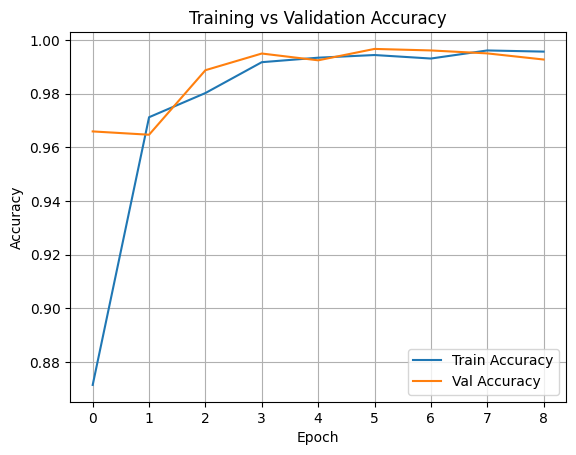

In [4]:
# === 4. 畫訓練準確度 === #
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training vs Validation Accuracy')
plt.show()


==== Fold 1 ====
  驗證資料標籤分布： [20000 40000]


2025-05-14 16:02:23.544498: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 384000000 exceeds 10% of free system memory.
2025-05-14 16:04:35.337949: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 96000000 exceeds 10% of free system memory.
2025-05-14 16:13:35.938680: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 96000000 exceeds 10% of free system memory.


1875/1875 [==============================] - 28s 13ms/step
  Fold 1 AUC: 0.656

==== Fold 2 ====
  驗證資料標籤分布： [20000 40000]
1875/1875 [==============================] - 28s 13ms/step
  Fold 2 AUC: 0.993

==== Fold 3 ====
  驗證資料標籤分布： [20000 40000]
1875/1875 [==============================] - 30s 13ms/step
  Fold 3 AUC: 0.990

==== Fold 4 ====
  驗證資料標籤分布： [20000 40000]
1875/1875 [==============================] - 28s 12ms/step
  Fold 4 AUC: 0.988

==== Fold 5 ====
  驗證資料標籤分布： [20000 40000]
1875/1875 [==============================] - 28s 12ms/step
  Fold 5 AUC: 0.983


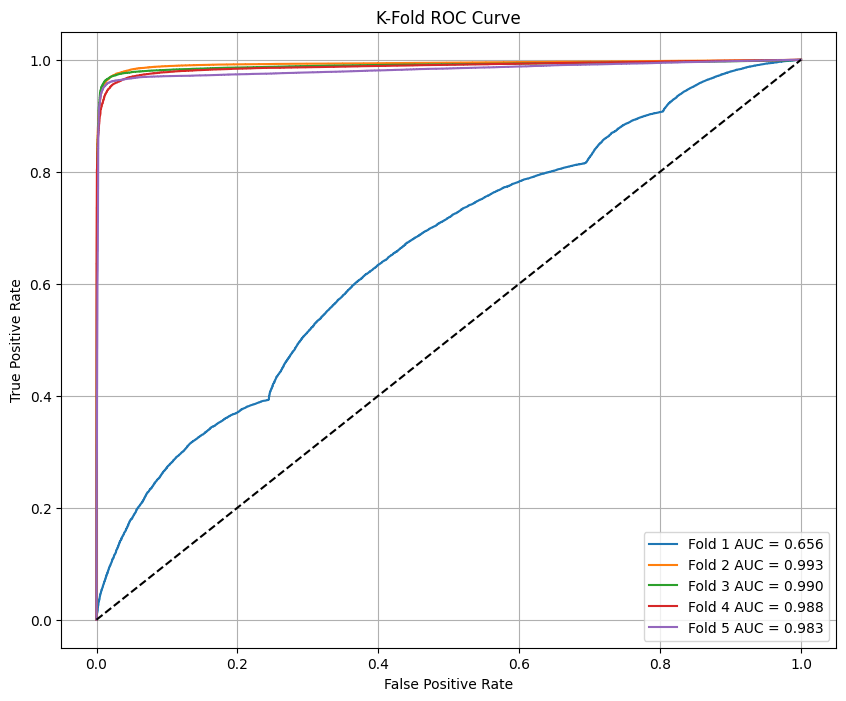

In [5]:
# === 5. K-Fold Cross Validation with ROC Curve === #
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
plt.figure(figsize=(10, 8))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n==== Fold {fold + 1} ====")
    print("  驗證資料標籤分布：", np.bincount(y[val_idx].astype(int)))

    # 資料切分
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # 建立模型
    model = models.Sequential([
        layers.Input(shape=(200, 2)),
        layers.Bidirectional(layers.LSTM(64, unroll=True)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid',
                     kernel_regularizer=regularizers.l2(0.01))
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 模型訓練
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=5, batch_size=128, verbose=0)

    # 預測與計算 AUC
    y_pred_prob = model.predict(X_val).flatten()
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    print(f"  Fold {fold + 1} AUC: {roc_auc:.3f}")

    # 繪製 ROC 曲線
    plt.plot(fpr, tpr, label=f'Fold {fold + 1} AUC = {roc_auc:.3f}')

# 對角線參考
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
